### 경상남도 읍면동 지도에 버스 정류장 위치 데이터 표시
* 대한민국 최신 행정구역(SHP) (읍면동 데이터): http://www.gisdeveloper.co.kr/?p=233
* 국토교통부_전국 버스정류장 위치정보: https://www.data.go.kr/data/15067528/fileData.do

1. 경상남도 읍면동 공간데이터 추출
2. 경상남도 버스 정류장 위치데이터 추출
3. 버스 정류장 공간데이터 내에 이상치, 결측치 처리
4. EPSG:5179로 통일
5. 버스 정류장 공간데이터 중 경상남도에 속하지 않는 데이터 필터링
6. 경상남도 위에 버스 정류장 위치 표시 

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["figure.figsize"] = (10, 10)

import warnings
warnings.filterwarnings("ignore")

In [3]:
## 읍면동 공간데이터 불러오기
emd = gpd.read_file(
    "../../data/emd_20230729/emd.shp", 
    encoding="cp949", 
    )

## 읍면동 경상남도 추출
emd = emd[emd["EMD_CD"].apply(lambda x: x[:2] == "48")]

## crs값 설정
emd = emd.set_crs(crs="EPSG:5179")
print(emd.crs)

EPSG:5179


In [5]:
## 정류장 데이터 불러오기
busstop = pd.read_csv("../../data/버스기본데이터/국토교통부_전국 버스정류장 위치정보_20231016.csv", encoding="cp949")

## 경남만 불러오기
busstop = busstop[busstop["도시명"].apply(lambda x: True if "경상남도" in x else False)]

## 이상치 및 결측치 처리
busstop = busstop.drop(index=94785)
busstop.loc[140553, "위도"] = 34.927810
busstop.loc[140553, "경도"] = 128.06807
busstop.loc[140554, "위도"] = 34.927663
busstop.loc[140554, "경도"] = 128.06838

## geo data 형태로 변형
busstop = gpd.GeoDataFrame(
    busstop, 
    geometry=gpd.points_from_xy(busstop['경도'], busstop['위도'])
    )

## crs값 설정
busstop = busstop.set_crs(crs="EPSG:4326")
busstop = busstop.to_crs(epsg=5179)
print(busstop.crs)

EPSG:5179


##### 경상남도 내에 있는 버스 정류장 추출 

In [6]:
## busstop데이터의 point만 추출
busstop_points = busstop[["geometry"]]
## emd데이터의 polygon만 추출
emd_polygons = emd[["geometry"]]

## 공간 join 수행 (points와 polygons 간의 'within' 관계를 기반으로)
busstop_within_emd = gpd.sjoin(
    left_df=busstop_points, 
    right_df=emd_polygons, 
    how='inner', 
    predicate='within'
    )

## joined DataFrame에는 points와 일치하는 polygons의 정보가 포함됨
busstop_within_emd = busstop_within_emd.drop(columns='index_right')

## 원본 버스 정류장 데이터에 조인
busstop_within_emd = gpd.sjoin(
    left_df=busstop, 
    right_df=busstop_within_emd, 
    how="right", 
    )

In [9]:
len(busstop) - len(busstop_within_emd)

1436

In [7]:
busstop_within_emd

,index_left,정류장번호,정류장명,위도,경도,정보수집일,모바일단축번호,도시코드,도시명,관리도시명,geometry
10276,10276,CWB379000566,구암고등학교,35.246296,128.593978,2023-10-16,420615.0,38010,경상남도 창원시,창원,POINT (1099529.31 1695090.322)
10277,10277,CWB379000567,사격장입구,35.244923,128.683156,2023-10-16,107508.0,38010,경상남도 창원시,창원,POINT (1107644.846 1695031.102)
10278,10278,CWB379000568,장애인복지회관입구,35.244960,128.673597,2023-10-16,119117.0,38010,경상남도 창원시,창원,POINT (1106775.068 1695024.86)
10279,10279,CWB379000570,장애인복지회관입구,35.244773,128.673243,2023-10-16,119118.0,38010,경상남도 창원시,창원,POINT (1106743.105 1695003.68)
10280,10280,CWB379000573,지귀상가,35.244778,128.659437,2023-10-16,119111.0,38010,경상남도 창원시,창원,POINT (1105486.945 1694989.456)
...,...,...,...,...,...,...,...,...,...,...,...
203796,203796,YSB5166,사과나무집,35.491970,128.989600,2023-10-16,5166.0,38100,경상남도 양산시,양산,POINT (1135114.889 1722807.741)
203797,203797,YSB5167,이지더원3차,35.322630,129.027700,2023-10-16,5167.0,38100,경상남도 양산시,양산,POINT (1138861.264 1704077.947)
203798,203798,YSB5168,반도유보라6차,35.317890,129.027500,2023-10-16,5168.0,38100,경상남도 양산시,양산,POINT (1138851.189 1703551.929)
203799,203799,YSB5169,양우내안애6차,35.318010,129.023400,2023-10-16,5169.0,38100,경상남도 양산시,양산,POINT (1138478.261 1703559.5)


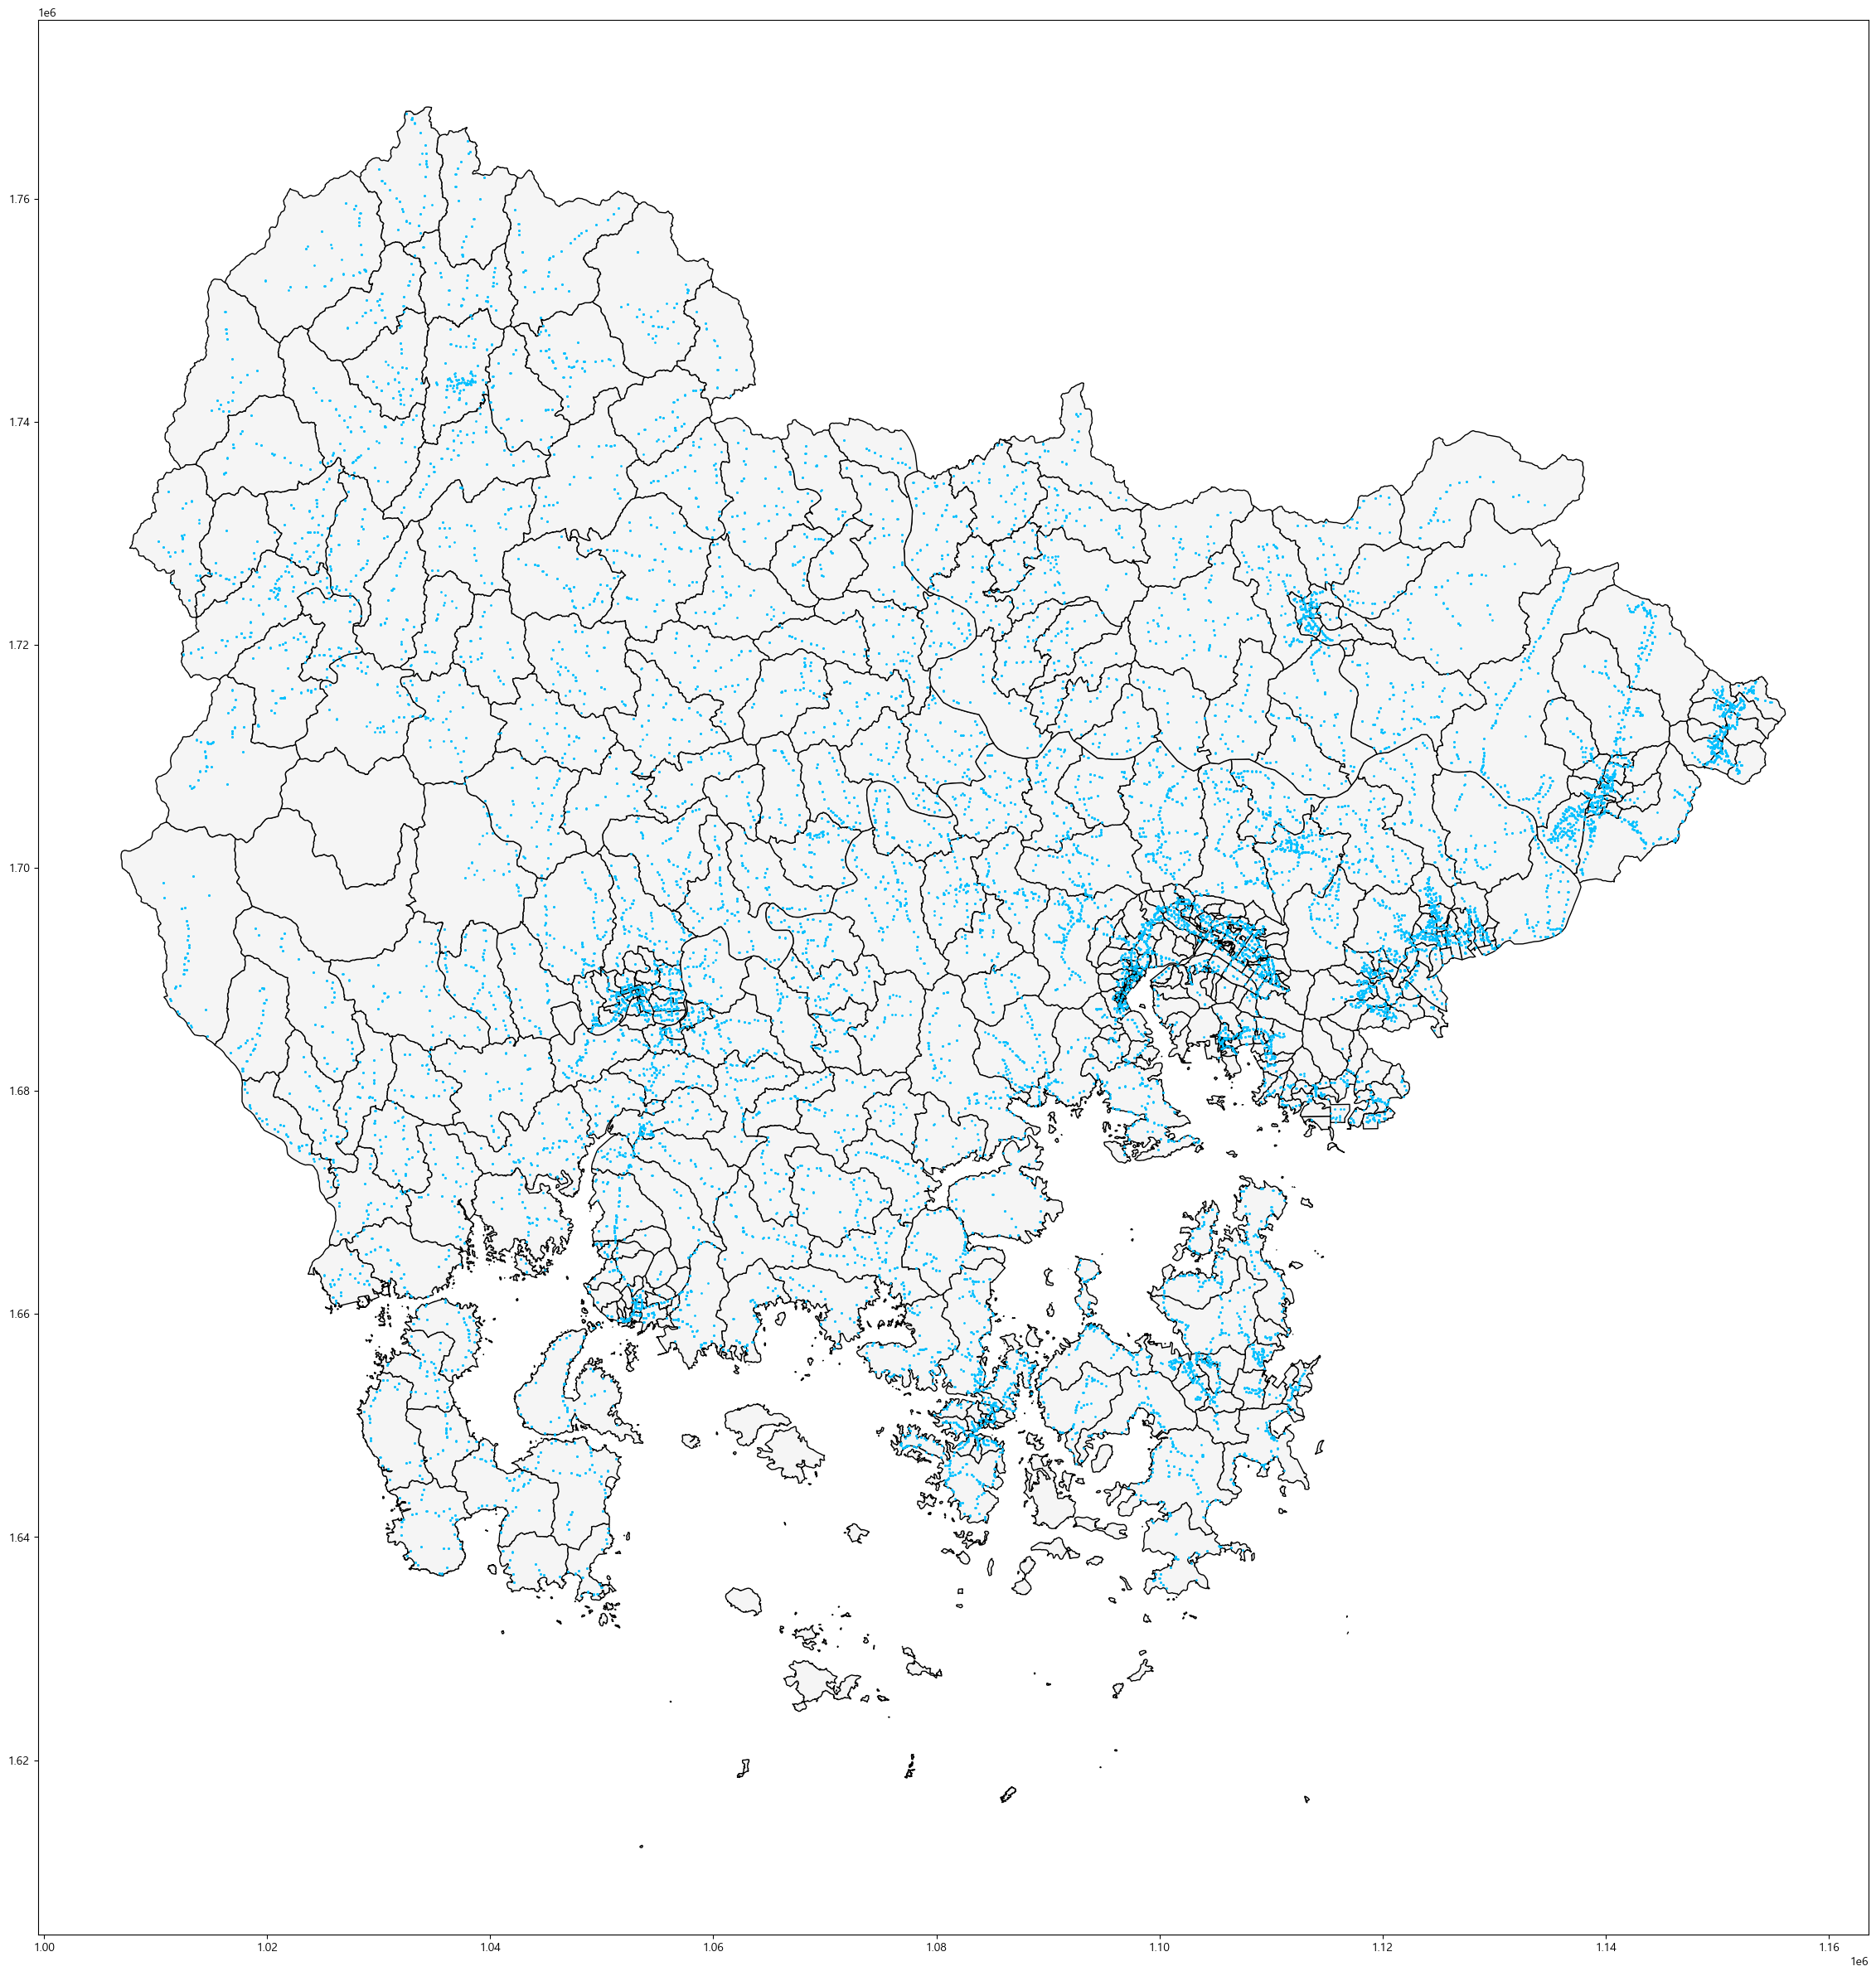

In [9]:
## 읍면동 틀 그리기
ax = emd.plot(
    figsize = (30, 30), 
    color = "whitesmoke", 
    edgecolor = "black", 
    linewidth = 1,
    column = "EMD_KOR_NM",
    legend = True, 
    categorical = True
)

## 버스 정류장 위치 확인
busstop_within_emd.plot(
    ax = ax, 
    color = "deepskyblue", 
    markersize = 1
)
plt.show()